In [2]:
%matplotlib inline
%run utils.py
import os.path as osp
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_pub = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstracts.csv'))
df_pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52174 entries, 0 to 52173
Data columns (total 5 columns):
abstract    46582 non-null object
date        18497 non-null object
id          52174 non-null int64
terms       52174 non-null object
title       52172 non-null object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [4]:
df_ct = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_tcell_types.csv'))
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11524 entries, 0 to 11523
Data columns (total 6 columns):
type        11524 non-null object
count       11524 non-null int64
id          11524 non-null int64
type_key    7045 non-null object
type_lbl    7045 non-null object
type_lvl    7045 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 540.3+ KB


In [5]:
df_pr = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_proteins_resolved.csv'))
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61427 entries, 0 to 61426
Data columns (total 9 columns):
id            61427 non-null int64
start         61427 non-null int64
end           61427 non-null int64
value         61427 non-null object
class         61427 non-null object
value_norm    61427 non-null object
value_lbl     61427 non-null object
value_sym     17196 non-null object
is_common     61427 non-null bool
dtypes: bool(1), int64(3), object(5)
memory usage: 3.8+ MB


## Merge

In [8]:
df = pd.merge(
    df_ct.add_prefix('ct_').rename(columns={'ct_id': 'id'}),
    df_pr.add_prefix('pr_').rename(columns={'pr_id': 'id'}),
    on='id',
    how='inner'
)
# Remove rows where there is no cell type classification
df = df[df['ct_type_key'].notnull()]

df = pd.merge(
    df, df_pub.add_prefix('pub_').rename(columns={'pub_id': 'id'}), 
    on='id', how='inner'
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70860 entries, 0 to 70859
Data columns (total 18 columns):
ct_type          70860 non-null object
ct_count         70860 non-null int64
id               70860 non-null int64
ct_type_key      70860 non-null object
ct_type_lbl      70860 non-null object
ct_type_lvl      70860 non-null float64
pr_start         70860 non-null int64
pr_end           70860 non-null int64
pr_value         70860 non-null object
pr_class         70860 non-null object
pr_value_norm    70860 non-null object
pr_value_lbl     70860 non-null object
pr_value_sym     19644 non-null object
pr_is_common     70860 non-null bool
pub_abstract     70860 non-null object
pub_date         44627 non-null object
pub_terms        70860 non-null object
pub_title        70860 non-null object
dtypes: bool(1), float64(1), int64(4), object(12)
memory usage: 9.8+ MB


In [20]:
df_pr_cts = (
    # Group by doc + cell type + protein to get protein mention count
    df.groupby(['id', 'ct_type_key', 'ct_type_lbl', 'ct_type_lvl', 'pr_value_lbl'])
    .size().rename('pr_count').reset_index()
    
    # Regroup by cell type + protein to get count across all docs
    .groupby(['ct_type_key', 'ct_type_lbl', 'ct_type_lvl', 'pr_value_lbl'])['pr_count']
    .sum().rename('pr_count').reset_index()
)
df_pr_cts.head()

,ct_type_key,ct_type_lbl,ct_type_lvl,pr_value_lbl,pr_count
0,MAIT,Mucosal-associated Invariant T,1.0,10,1
1,MAIT,Mucosal-associated Invariant T,1.0,21,1
2,MAIT,Mucosal-associated Invariant T,1.0,5AMINO6D,2
3,MAIT,Mucosal-associated Invariant T,1.0,APC,1
4,MAIT,Mucosal-associated Invariant T,1.0,AS,1


In [16]:
# # Group by paper, cell type, and resolved protein to get protein mention count, then
# # group by paper and protein to get list of associated cell types and protein mention count
# df_pr_cts = df.groupby(['id', 'ct_type_key', 'ct_type_lbl', 'ct_type_lvl', 'pr_value_lbl'])\
#     .size().rename('pr_count').reset_index()\
#     .groupby(['id', 'pr_value_lbl'])\
#     .apply(lambda g: pd.Series({'ct_type_keys': g['ct_type_key'].tolist(), 'pr_count': g['pr_count'].iloc[0]}))\
#     .reset_index()
# df_pr_cts.head()

In [21]:
# Pivot to docs by terms (proteins) with values as number of times protein mentioned in doc
df_pr_cts_mat = df_pr_cts.pivot_table(
    index=['ct_type_key', 'ct_type_lbl', 'ct_type_lvl'], 
    columns='pr_value_lbl', 
    values='pr_count'
)
df_pr_cts_mat.shape

(45, 5292)

In [22]:
df_pr_cts_mat.head()

,,pr_value_lbl,070,1.92±0.32,10,10TITIN,11PROTEINKINASES,125D3,125DIHYDROXYVITAMINDHYDROXYLASE,125VITD3,1512C,16KDα,...,δLIKE1,δTCS1,δTCS1/A13,κB,‑8,–LIKE,↑IL17A,∼30%,∼3040%,∼92
ct_type_key,ct_type_lbl,ct_type_lvl,,,,,,,,,,,,,,,,,,,,,
MAIT,Mucosal-associated Invariant T,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NKT,Natural Killer T,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OKT,Ortho-Kung T Cell,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TC0,Tc0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TC1,Tc1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
def get_tfidf(mat):
    # Assume mat is ndocs x nterms
    if mat.isnull().any().any():
        mat = mat.fillna(0)
    # Compute percent of docs containing each term
    v_idf = (mat > 0).mean(axis=0)
    v_idf = (1./v_idf).apply(np.log) # Invert and apply log per tf-idf def.
    assert v_idf.ndim == 1 and v_idf.shape[0] == mat.shape[1]
    
    # Get doc-wise (i.e. row-wise) max term frequency and divide each row by it
    v_max = mat.max(axis=1)
    assert v_max.ndim == 1 and v_max.shape[0] == mat.shape[0]
    v_tf = mat.div(v_max.values, axis=0)
    v_tf = .5 + .5 * v_tf # per tf-idf definition
    assert v_tf.shape == mat.shape
    
    # Multiply tf and idf
    v_tfidf = v_tf.mul(v_idf.values, axis=1)
    assert v_tfidf.shape == mat.shape
    return v_tfidf

def get_scores(mat):
    # Assume mat is ndocs x nterms
    if mat.isnull().any().any():
        mat = mat.fillna(0)
    # Compute percent of docs containing each term
    v_avg = mat.mean(axis=0)
    return mat.div(v_avg.values, axis=1)

def get_ranks(mat):
    # Assume mat is ndocs x nterms
    if mat.isnull().any().any():
        mat = mat.fillna(0)
    return mat.apply(np.arcsinh)

#df_pr_score = get_tfidf(df_pr_cts_mat)
#df_pr_score = get_scores(df_pr_cts_mat)
df_pr_score = get_ranks(df_pr_cts_mat)
df_pr_score.head()

,,pr_value_lbl,070,1.92±0.32,10,10TITIN,11PROTEINKINASES,125D3,125DIHYDROXYVITAMINDHYDROXYLASE,125VITD3,1512C,16KDα,...,δLIKE1,δTCS1,δTCS1/A13,κB,‑8,–LIKE,↑IL17A,∼30%,∼3040%,∼92
ct_type_key,ct_type_lbl,ct_type_lvl,,,,,,,,,,,,,,,,,,,,,
MAIT,Mucosal-associated Invariant T,1.0,0.0,0.0,0.881374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NKT,Natural Killer T,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OKT,Ortho-Kung T Cell,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TC0,Tc0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TC1,Tc1,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
n_pr_limit = 10
df_pr_top = df_pr_score.stack().rename('value').reset_index()\
    .groupby(['ct_type_key', 'ct_type_lbl', 'ct_type_lvl'], group_keys=False)\
    .apply(lambda g: g.sort_values('value', ascending=False).head(n_pr_limit))
assert (df_pr_top.groupby(['ct_type_key', 'ct_type_lbl', 'ct_type_lvl']).size() == n_pr_limit).all()
df_pr_top.head()

,ct_type_key,ct_type_lbl,ct_type_lvl,pr_value_lbl,value
3360,MAIT,Mucosal-associated Invariant T,1.0,MR1,5.112024
4587,MAIT,Mucosal-associated Invariant T,1.0,TCR,4.700563
959,MAIT,Mucosal-associated Invariant T,1.0,CD8,4.406868
704,MAIT,Mucosal-associated Invariant T,1.0,CD161,4.382183
2363,MAIT,Mucosal-associated Invariant T,1.0,IFNγ,4.127394


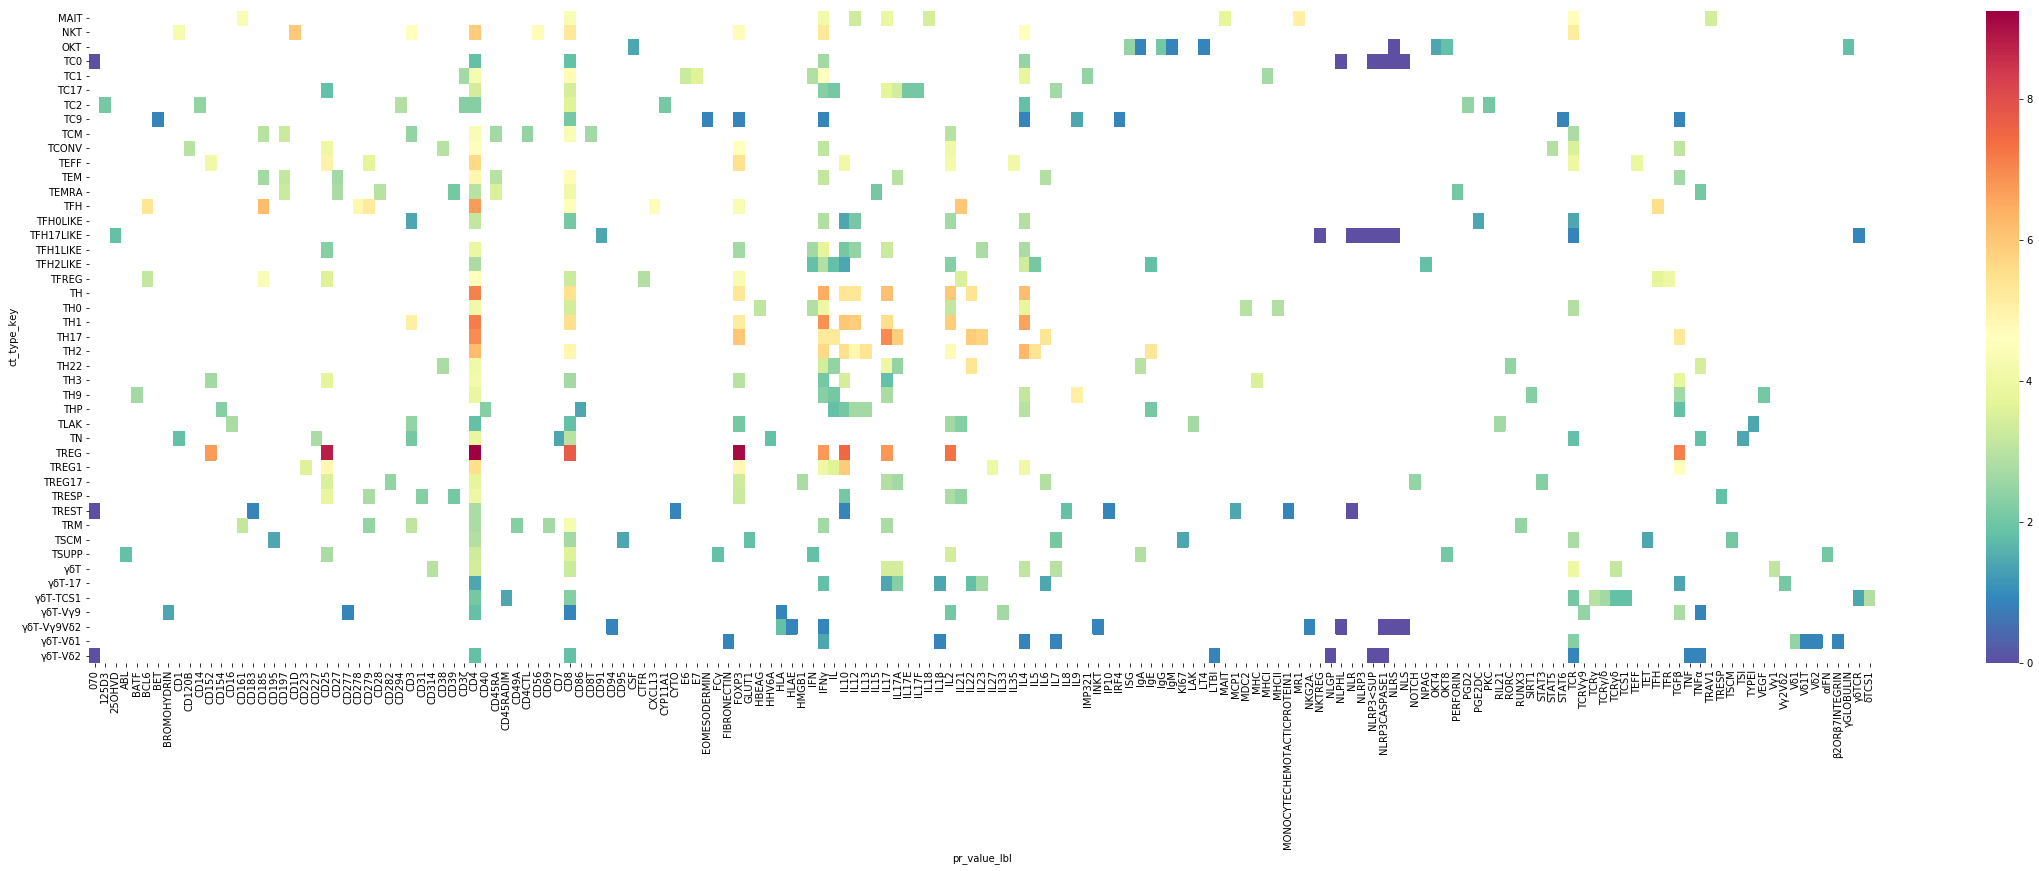

In [83]:
df_plt = df_pr_top.pivot_table(index='ct_type_key', columns='pr_value_lbl', values='value')
sns.heatmap(df_plt, xticklabels=1, yticklabels=1, cmap='Spectral_r')
plt.gcf().set_size_inches(40, 12)

In [24]:
# c_typ = 'TRM'
# c_pr = df[df['ct_type_key'] == c_typ]['pr_value_lbl'].dropna().unique()
# c_id = df[df['ct_type_key'] == c_typ]['id'].unique()

# df_pr_top = df_pr_tfidf.filter(items=c_id, axis=0)
# df_pr_top = df_pr_top.filter(items=df_pr_top.std(axis=0).sort_values(ascending=False).head(40).index.values)
# sns.heatmap(df_pr_top, xticklabels=1, cmap='Spectral_r')
# plt.gcf().set_size_inches(16, 6)

In [25]:
#df_lng[df_lng['ct_type_key'] == 'TFH'].groupby('pr_value_lbl')['id'].nunique().sort_values()